## 0. Libarary 불러오기 및 경로설정

In [1]:
# Baseline
from EDA import show_images
from dataset import convert_to_dataloader
from dataset import TrainDataset, TestDataset
from loss import F1Loss, FocalLoss
from train import seed_everything, train, eval
from inference import test

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image # tensor to pil_image
import torchvision.models as models
import torchvision.transforms as T

In [2]:
# 데이터셋 폴더 경로를 지정
train_dir = '../../../../input/data/train'
test_dir = '../../../../input/data/eval'
model_dir = '../../../../code/models'

In [3]:
print(f"CUDA: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUDA: True


In [4]:
seed_everything(42)
BATCH_SIZE = 70
LR = 0.0001
EPOCH = 5

In [5]:
train_csv = pd.read_csv(os.path.join(train_dir, 'train.csv'))
train_csv.tail(3)

,id,gender,race,age,path
2697,006956,male,Asian,19,006956_male_Asian_19
2698,006957,male,Asian,20,006957_male_Asian_20
2699,006959,male,Asian,19,006959_male_Asian_19


In [6]:
mapping_gender = lambda x: int(x == "female")
mapping_age = lambda x: min(2, x // 30)
mapping_mask = lambda x: x.startswith('mask') and 0 or (x.startswith('incorrect') and 1 or 2)

In [7]:
# pre-processing
# path to image_path 변경
image_dir = os.path.join(train_dir, 'images')

train_meta = pd.DataFrame()
for i in range(len(train_csv)):
    _, gender, _, age, path = train_csv.iloc[i]
    image_path = os.path.join(image_dir, path)

    li = []
    for f in os.listdir(image_path):
        if not f.startswith('.'):
            target = 6*mapping_gender(gender) + 3*mapping_age(age) + mapping_mask(f)
            li.append((target, os.path.join(image_path, f)))
    li = pd.DataFrame({name: data for name, data in  zip(['y', 'path'], zip(*li))})    
    train_meta = train_meta.append(li, ignore_index = True) # 뒤에 계속 합쳐두기
train_meta.tail(3)

,y,path
18897,2,../../../../input/data/train/images/006959_mal...
18898,1,../../../../input/data/train/images/006959_mal...
18899,2,../../../../input/data/train/images/006959_mal...


In [8]:
# train, test dataset 나누기
X_train, X_eval, y_train, y_eval = train_test_split(
        train_meta.path.to_numpy(), 
        train_meta.y.to_numpy(), 
        test_size=0.2, shuffle=False)

print(X_train.shape, y_train.shape)
print(X_eval.shape, y_eval.shape)

(15120,) (15120,)
(3780,) (3780,)


In [30]:
transform = transforms.Compose([
    T.CenterCrop((320, 256)),
    ToTensor(),
    T.ColorJitter(0.1, 0.1, 0.1, 0.1),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [27]:
train_ds = TrainDataset(X_train, y_train, transform)
eval_ds = TrainDataset(X_eval, y_eval, transform)

len(train_ds), len(eval_ds)

(15120, 3780)

In [28]:
train_loader = convert_to_dataloader(train_ds, BATCH_SIZE, True)
eval_loader = convert_to_dataloader(eval_ds, BATCH_SIZE, True)

len(train_loader)*BATCH_SIZE, len(eval_loader)*BATCH_SIZE

(15120, 3780)

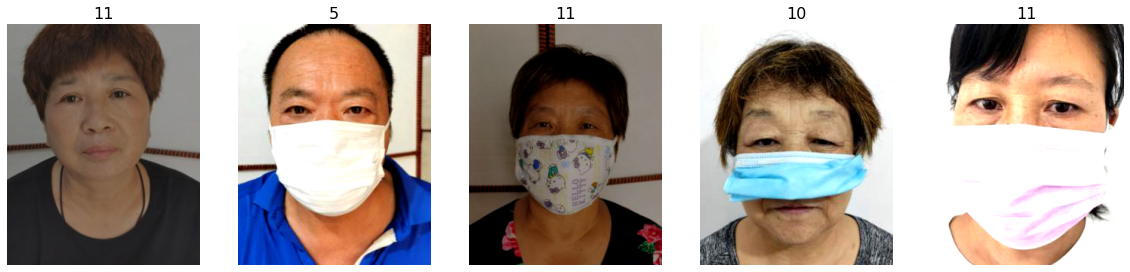

In [29]:
# CenterCrop(300), ColorJitter(.5, .3)
show_images(train_ds, [7, 80, 43, 2595, 15000], 1, 5)

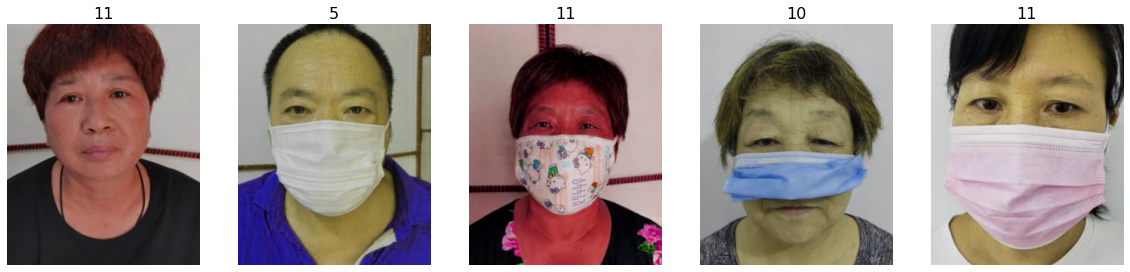

In [25]:
# CenterCrop(300), ColorJitter(0.1, 0.1, 0.1, 0.1)
show_images(train_ds, [7, 80, 43, 2595, 15000], 1, 5)

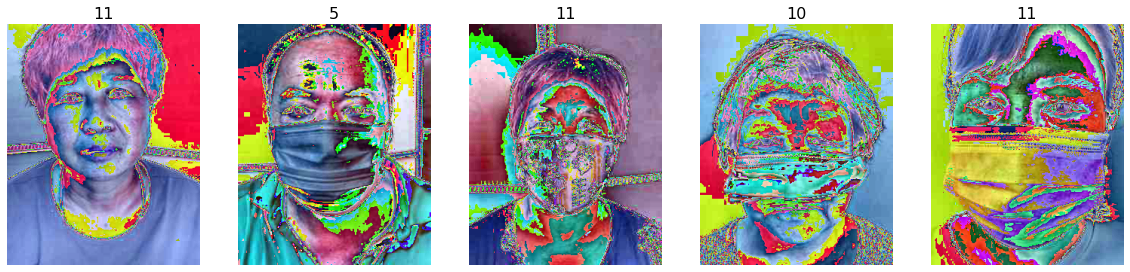

In [14]:
# CenterCrop(300), ColorJitter(0.1, 0.1, 0.1, 0.1), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
show_images(train_ds, [7, 80, 43, 2595, 15000], 1, 5)

## 1. Model 정의

In [16]:
model = models.resnet34(pretrained=True).to(device)
loss_fn = FocalLoss()
optm = torch.optim.Adam(model.parameters(), lr=LR)

num_classes = 18
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes).to(device)

# for x in model.children():
#     print(x)

In [17]:
train(train_loader, model, loss_fn, optm, EPOCH)

epoch: 0 Loss: 3.0034 Acc: 0.0143
epoch: 0 Loss: 0.1735 Acc: 0.7975
epoch: 0 Loss: 0.0958 Acc: 0.8585
epoch: 1 Loss: 0.0112 Acc: 1.0000
epoch: 1 Loss: 0.0293 Acc: 0.9758
epoch: 1 Loss: 0.0198 Acc: 0.9770
epoch: 2 Loss: 0.0016 Acc: 1.0000
epoch: 2 Loss: 0.0022 Acc: 0.9914
epoch: 2 Loss: 0.0022 Acc: 0.9896
epoch: 3 Loss: 0.0017 Acc: 1.0000
epoch: 3 Loss: 0.0015 Acc: 0.9959
epoch: 3 Loss: 0.0011 Acc: 0.9959
epoch: 4 Loss: 0.0069 Acc: 0.9857
epoch: 4 Loss: 0.0011 Acc: 0.9939
epoch: 4 Loss: 0.0105 Acc: 0.9936
done!


In [18]:
eval(eval_loader, model)

done!
Accuracy: 0.8950
F1 Loss: 0.6686


## 2. Test Dataset 정의

## 3. Inference

In [19]:
# torch.save(model, os.path.join(model_dir, "resnet34_crossentropy_adam.pt"))
# model.load_state_dict(torch.load(model_path, map_location=device), strict=False)

In [20]:
model_name = str(model).split('(')[0]
loss_name = str(loss_fn).split('(')[0]
optm_name = str(optm).split(' ')[0]

In [21]:
# test(test_dir, model, transform, saving_filename=f'{model_name}_{loss_name}_{optm_name}.csv')